In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold
from scipy.stats import pearsonr, chi2_contingency
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import cross_val_score, StratifiedKFold
import warnings
warnings.filterwarnings('ignore')

In [16]:
# 한글 폰트 설정 (matplotlib)
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

In [17]:
print("="*60)
print("▶ 금융상품 추천 모델링 - 데이터 및 변수 설정")
print("="*60)

# ==========================================
# 1단계: 데이터 로드
# ==========================================
print("\n1. 데이터 로드 중...")

try:
    # CSV 파일 읽기
    original_df = pd.read_csv('data/SCFP2022_한글.csv')
    print(f"✅ 데이터 로드 성공: {original_df.shape}")
    print(f"   - 행 수: {original_df.shape[0]:,}")
    print(f"   - 열 수: {original_df.shape[1]:,}")
    
    # 컬럼명 확인
    print(f"\n📋 컬럼명 미리보기 (처음 10개):")
    for i, col in enumerate(original_df.columns[:10]):
        print(f"   {i+1:2d}. {col}")
    
except FileNotFoundError:
    print("❌ 파일을 찾을 수 없습니다. 파일명과 경로를 확인해주세요.")
    original_df = None

▶ 금융상품 추천 모델링 - 데이터 및 변수 설정

1. 데이터 로드 중...
✅ 데이터 로드 성공: (22975, 357)
   - 행 수: 22,975
   - 열 수: 357

📋 컬럼명 미리보기 (처음 10개):
    1. 연도
    2. 연도코드
    3. 가중치
    4. 가구주성별
    5. 연령
    6. 연령대분류
    7. 교육수준
    8. 교육수준분류
    9. 결혼상태
   10. 자녀수


In [18]:
# ==========================================
# 2단계: 종속변수 정의
# ==========================================
print("\n" + "="*60)
print("2. 종속변수 설정")
print("="*60)

# 실제 금액 컬럼명에 맞춰 종속변수 매핑 (금액 → 보유여부 변환)
target_mapping = {
    'LIQ': '유동성자산',           # 유동성자산 금액이 0 이상이면 1(보유), 아니면 0(미보유)
    'CDS': '양도성예금증서',        # 양도성예금증서 금액이 0 이상이면 1(보유), 아니면 0(미보유)  
    'NMMF': '비머니마켓펀드',      # 비머니마켓펀드 금액이 0 이상이면 1(보유), 아니면 0(미보유)
    'STOCKS': '주식보유',          # 주식 금액이 0 이상이면 1(보유), 아니면 0(미보유)
    'RETQLIQ': '퇴직준비금유동성'   # 퇴직준비금유동성 금액이 0 이상이면 1(보유), 아니면 0(미보유)
}

targets = list(target_mapping.keys())
print(f"🎯 종속변수: {targets}")


2. 종속변수 설정
🎯 종속변수: ['LIQ', 'CDS', 'NMMF', 'STOCKS', 'RETQLIQ']


In [19]:
# ==========================================
# 3단계: 독립변수 정의 (효율적 분류)
# ==========================================
print("\n" + "="*60)
print("3. 독립변수 설정")
print("="*60)

# 핵심 인구통계학적 변수 (12개)
demographic_features = [
    # 기본 인구통계 (5개)
    '연령',           # 투자성향의 핵심 결정요인
    '가구주성별',      # 투자 패턴 차이
    '교육수준',       # 금융지식과 직결
    '결혼상태',       # 가계 의사결정 구조
    '자녀수',         # 미래 재정계획 영향
    
    # 직업/고용 (3개)
    '직업분류1',      # 소득 안정성
    '노동력참여상태',  # 고용 상태
    '산업분류',       # 업종별 특성
    
    # 사회경제적 배경 (2개)
    '인종분류',       # 사회경제적 배경
    '생애주기분류',    # 생애단계별 금융니즈
    
    # 금융 행동/성향 (2개)
    '금융위험감수',    # 투자 위험선호도 (핵심!)
    '저축여부'        # 저축 행태
]

# 핵심 금융 변수 (15개)
financial_features = [
    # 소득 관련 (4개)
    '총소득',         # 투자규모 결정의 기본
    '급여소득',       # 안정소득
    '사업농업소득',    # 변동소득
    '정상소득',       # 소득 안정성
    
    # 자산 규모 (4개)
    '순자산',         # 전체 재정상황 (핵심!)
    '총금융자산',      # 투자가능 자금
    '총비금융자산',    # 부동산 등 실물자산
    '주택보유',       # 주요 실물자산
    
    # 기존 투자 현황 (4개) - 종속변수와 겹치지 않는 것들
    '주식보유',       # 주식 투자 경험
    '현금가치생명보험', # 보험성 금융상품
    '퇴직자본',       # 퇴직연금 자산
    'IRA계좌보유여부', # 개인연금 보유
    
    # 투자 성향/경험 (3개)
    '중개계좌보유여부', # 투자 활동성
    '거래활동여부',    # 적극적 투자 여부
    '금융지식'        # 금융상품 이해도
]

print(f"👥 인구통계학적 변수: {len(demographic_features)}개")
print(f"💰 금융 변수: {len(financial_features)}개")
print(f"📊 총 독립변수: {len(demographic_features) + len(financial_features)}개")



3. 독립변수 설정
👥 인구통계학적 변수: 12개
💰 금융 변수: 15개
📊 총 독립변수: 27개


In [20]:
# ==========================================
# 4단계: 데이터프레임 분할 및 종속변수 생성
# ==========================================
print("\n" + "="*60)
print("4. 데이터 분할 및 종속변수 생성")
print("="*60)

if original_df is not None:
    # 데이터프레임 복사
    df_demographic = original_df.copy()
    df_financial = original_df.copy()
    
    # 종속변수 생성 (금액 기반 → 보유 여부 이진 분류 변환)
    print("🔄 종속변수 생성 중 (금액 → 보유여부 변환)...")
    for target, amount_col in target_mapping.items():
        if amount_col in original_df.columns:
            # 핵심: 금액이 0보다 크면 1(보유), 아니면 0(미보유)로 변환
            df_financial[target] = (original_df[amount_col] > 0).astype(int)
            df_demographic[target] = (original_df[amount_col] > 0).astype(int)
            
            # 보유율 및 클래스 불균형 확인
            holding_rate = df_financial[target].mean()
            total_holders = df_financial[target].sum()
            total_non_holders = len(df_financial) - total_holders
            avg_amount = original_df[original_df[amount_col] > 0][amount_col].mean()
            
            # 클래스 불균형 비율 계산
            if holding_rate > 0:
                imbalance_ratio = (1 - holding_rate) / holding_rate  # 미보유:보유 비율
            else:
                imbalance_ratio = float('inf')
            
            print(f"   ✅ {target} ({amount_col}):")
            print(f"      - 보유율: {holding_rate*100:.1f}% ({total_holders:,}명)")
            print(f"      - 미보유율: {(1-holding_rate)*100:.1f}% ({total_non_holders:,}명)")
            print(f"      - 클래스 불균형 비율: {imbalance_ratio:.2f}:1 (미보유:보유)")
            print(f"      - 보유자 평균 금액: ${avg_amount:,.0f}" if not pd.isna(avg_amount) else "      - 보유자 평균 금액: 계산 불가")
            
            # 클래스 불균형 경고
            if imbalance_ratio > 4:  # 4:1 이상 불균형
                print(f"      ⚠️  심각한 클래스 불균형! 샘플링 기법 필요")
            elif imbalance_ratio > 2:  # 2:1 이상 불균형
                print(f"      ⚡ 클래스 불균형 있음. 가중치 조정 고려")
        else:
            print(f"   ❌ {amount_col} 컬럼을 찾을 수 없습니다.")


4. 데이터 분할 및 종속변수 생성
🔄 종속변수 생성 중 (금액 → 보유여부 변환)...
   ✅ LIQ (유동성자산):
      - 보유율: 98.5% (22,637명)
      - 미보유율: 1.5% (338명)
      - 클래스 불균형 비율: 0.01:1 (미보유:보유)
      - 보유자 평균 금액: $777,054
   ✅ CDS (양도성예금증서):
      - 보유율: 7.8% (1,792명)
      - 미보유율: 92.2% (21,183명)
      - 클래스 불균형 비율: 11.82:1 (미보유:보유)
      - 보유자 평균 금액: $1,382,777
      ⚠️  심각한 클래스 불균형! 샘플링 기법 필요
   ✅ NMMF (비머니마켓펀드):
      - 보유율: 20.0% (4,604명)
      - 미보유율: 80.0% (18,371명)
      - 클래스 불균형 비율: 3.99:1 (미보유:보유)
      - 보유자 평균 금액: $9,779,335
      ⚡ 클래스 불균형 있음. 가중치 조정 고려
   ✅ STOCKS (주식보유):
      - 보유율: 29.1% (6,689명)
      - 미보유율: 70.9% (16,286명)
      - 클래스 불균형 비율: 2.43:1 (미보유:보유)
      - 보유자 평균 금액: $11,483,156
      ⚡ 클래스 불균형 있음. 가중치 조정 고려
   ✅ RETQLIQ (퇴직준비금유동성):
      - 보유율: 59.1% (13,577명)
      - 미보유율: 40.9% (9,398명)
      - 클래스 불균형 비율: 0.69:1 (미보유:보유)
      - 보유자 평균 금액: $1,003,565


In [21]:
# ==========================================
# 5단계: 데이터 품질 체크
# ==========================================
print("\n" + "="*60)
print("5. 데이터 품질 체크")
print("="*60)

if original_df is not None:
    print(f"📊 데이터 기본 정보:")
    print(f"   - 금융 관련 데이터 크기: {df_financial.shape}")
    print(f"   - 사람정보 관련 데이터 크기: {df_demographic.shape}")
    print(f"   - 종속변수 존재 여부: {[col for col in targets if col in df_financial.columns]}")
    
    # 변수 존재 여부 확인
    financial_exists = [col for col in financial_features if col in df_financial.columns]
    demographic_exists = [col for col in demographic_features if col in df_demographic.columns]
    
    print(f"   - 금융 관련 독립변수 존재: {len(financial_exists)}/{len(financial_features)}개")
    print(f"   - 인구통계 독립변수 존재: {len(demographic_exists)}/{len(demographic_features)}개")
    
    # 결측값 확인
    print(f"\n🔍 결측값 체크:")
    
    # 금융 데이터 결측값
    if financial_exists:
        financial_missing = df_financial[financial_exists + [t for t in targets if t in df_financial.columns]].isnull().sum()
        if financial_missing.sum() > 0:
            print(f"   ⚠️ 금융 관련 결측값:")
            for col, missing in financial_missing[financial_missing > 0].items():
                print(f"      - {col}: {missing:,}개 ({missing/len(df_financial)*100:.1f}%)")
        else:
            print("   ✅ 금융 관련 데이터에 결측값 없음")
    
    # 인구통계 데이터 결측값
    if demographic_exists:
        demographic_missing = df_demographic[demographic_exists + [t for t in targets if t in df_demographic.columns]].isnull().sum()
        if demographic_missing.sum() > 0:
            print(f"   ⚠️ 인구통계 관련 결측값:")
            for col, missing in demographic_missing[demographic_missing > 0].items():
                print(f"      - {col}: {missing:,}개 ({missing/len(df_demographic)*100:.1f}%)")
        else:
            print("   ✅ 인구통계 관련 데이터에 결측값 없음")


5. 데이터 품질 체크
📊 데이터 기본 정보:
   - 금융 관련 데이터 크기: (22975, 362)
   - 사람정보 관련 데이터 크기: (22975, 362)
   - 종속변수 존재 여부: ['LIQ', 'CDS', 'NMMF', 'STOCKS', 'RETQLIQ']
   - 금융 관련 독립변수 존재: 15/15개
   - 인구통계 독립변수 존재: 12/12개

🔍 결측값 체크:
   ✅ 금융 관련 데이터에 결측값 없음
   ✅ 인구통계 관련 데이터에 결측값 없음


In [22]:
# ==========================================
# 5단계: 데이터 품질 체크
# ==========================================
print("\n" + "="*60)
print("5. 데이터 품질 체크")
print("="*60)

if original_df is not None:
    print(f"📊 데이터 기본 정보:")
    print(f"   - 금융 관련 데이터 크기: {df_financial.shape}")
    print(f"   - 사람정보 관련 데이터 크기: {df_demographic.shape}")
    print(f"   - 종속변수 존재 여부: {[col for col in targets if col in df_financial.columns]}")
    
    # 변수 존재 여부 확인
    financial_exists = [col for col in financial_features if col in df_financial.columns]
    demographic_exists = [col for col in demographic_features if col in df_demographic.columns]
    
    print(f"   - 금융 관련 독립변수 존재: {len(financial_exists)}/{len(financial_features)}개")
    print(f"   - 인구통계 독립변수 존재: {len(demographic_exists)}/{len(demographic_features)}개")
    
    # 포괄적 데이터 품질 체크
    print(f"\n🔍 포괄적 데이터 품질 체크:")
    
    # 1. 데이터 타입 및 인코딩 체크
    print(f"\n🔤 데이터 타입 및 인코딩 체크:")
    type_issues = {}
    for col in original_df.columns[:20]:  # 처음 20개만 체크
        dtype = original_df[col].dtype
        sample_values = original_df[col].dropna().head(3).tolist()
        
        # 숫자로 보이는데 문자열인 경우
        if dtype == 'object':
            try:
                numeric_conversion = pd.to_numeric(original_df[col], errors='coerce')
                if not numeric_conversion.isna().all():
                    conversion_rate = (1 - numeric_conversion.isna().mean()) * 100
                    if conversion_rate > 80:  # 80% 이상이 숫자로 변환 가능
                        type_issues[col] = f"숫자 변환 가능 ({conversion_rate:.1f}%)"
            except:
                pass
        
        print(f"   {col}: {dtype} - 샘플: {sample_values}")
    
    if type_issues:
        print(f"\n   ⚠️ 데이터 타입 이슈:")
        for col, issue in type_issues.items():
            print(f"      - {col}: {issue}")
    
    # 2. 중복 데이터 체크
    print(f"\n🔄 중복 데이터 체크:")
    total_rows = len(original_df)
    unique_rows = len(original_df.drop_duplicates())
    duplicate_count = total_rows - unique_rows
    duplicate_percentage = (duplicate_count / total_rows) * 100
    
    print(f"   전체 행 수: {total_rows:,}")
    print(f"   고유 행 수: {unique_rows:,}")
    if duplicate_count > 0:
        print(f"   ⚠️ 중복 행: {duplicate_count:,}개 ({duplicate_percentage:.2f}%)")
    else:
        print(f"   ✅ 중복 행 없음")
    
    # 3. 논리적 일관성 체크
    print(f"\n🧠 논리적 일관성 체크:")
    consistency_issues = []
    
    # 나이 관련 체크
    if '연령' in original_df.columns:
        age_issues = original_df[(original_df['연령'] < 18) | (original_df['연령'] > 100)]
        if len(age_issues) > 0:
            consistency_issues.append(f"연령 이상값: {len(age_issues)}개 (18세 미만 또는 100세 초과)")
    
    # 소득 관련 체크
    income_cols = ['총소득', '급여소득', '사업농업소득']
    available_income_cols = [col for col in income_cols if col in original_df.columns]
    if len(available_income_cols) >= 2:
        # 음수 소득 체크
        for col in available_income_cols:
            negative_income = original_df[original_df[col] < 0]
            if len(negative_income) > 0:
                consistency_issues.append(f"{col} 음수값: {len(negative_income)}개")
    
    # 자산 관련 체크
    if '순자산' in original_df.columns and '총자산' in original_df.columns:
        # 순자산이 총자산보다 큰 경우
        asset_inconsistency = original_df[original_df['순자산'] > original_df['총자산']]
        if len(asset_inconsistency) > 0:
            consistency_issues.append(f"순자산 > 총자산: {len(asset_inconsistency)}개")
    
    if consistency_issues:
        print(f"   ⚠️ 논리적 일관성 이슈:")
        for issue in consistency_issues:
            print(f"      - {issue}")
    else:
        print(f"   ✅ 논리적 일관성 양호")
    
    # 4. 데이터 완전성 체크 (Coverage)
    print(f"\n📊 데이터 완전성 체크:")
    completeness_report = {}
    
    # 핵심 변수들의 완전성
    key_variables = demographic_features + financial_features
    available_key_vars = [var for var in key_variables if var in original_df.columns]
    
    for var in available_key_vars[:10]:  # 처음 10개만 체크
        non_null_count = original_df[var].notna().sum()
        completeness_rate = (non_null_count / len(original_df)) * 100
        completeness_report[var] = completeness_rate
    
    # 완전성이 낮은 변수들
    low_completeness = {k: v for k, v in completeness_report.items() if v < 80}
    if low_completeness:
        print(f"   ⚠️ 완전성이 낮은 변수 (80% 미만):")
        for var, rate in sorted(low_completeness.items(), key=lambda x: x[1]):
            print(f"      - {var}: {rate:.1f}% 완전")
    else:
        print(f"   ✅ 핵심 변수들의 완전성 양호")
    
    # 5. 분포 치우침 및 정규성 체크
    print(f"\n📈 분포 특성 체크:")
    from scipy import stats
    
    distribution_summary = {}
    numeric_cols = [col for col in available_key_vars if col in original_df.columns and pd.api.types.is_numeric_dtype(original_df[col])]
    
    for col in numeric_cols[:5]:  # 처음 5개 수치형 변수만
        data = original_df[col].dropna()
        if len(data) > 10:
            skewness = stats.skew(data)
            kurtosis = stats.kurtosis(data)
            
            # 치우침 정도 평가
            if abs(skewness) > 2:
                skew_level = "심각한 치우침"
            elif abs(skewness) > 1:
                skew_level = "중간 치우침"
            else:
                skew_level = "정상"
            
            distribution_summary[col] = {
                'skewness': skewness,
                'kurtosis': kurtosis,
                'skew_level': skew_level
            }
    
    if distribution_summary:
        print(f"   📊 분포 치우침 분석:")
        for col, stats_info in distribution_summary.items():
            print(f"      - {col}: {stats_info['skew_level']} (왜도: {stats_info['skewness']:.2f})")
    
    # 6. 샘플링 편향 체크
    print(f"\n⚖️ 샘플링 편향 체크:")
    sampling_issues = []
    
    # 지역 분포 체크
    if '인종분류' in original_df.columns:
        race_dist = original_df['인종분류'].value_counts(normalize=True) * 100
        dominant_group = race_dist.iloc[0]
        if dominant_group > 80:
            sampling_issues.append(f"인종 편향: 주요 그룹 {dominant_group:.1f}%")
    
    # 소득 분포 체크
    if '총소득' in original_df.columns:
        income_data = original_df['총소득'].dropna()
        if len(income_data) > 0:
            income_q90 = income_data.quantile(0.9)
            income_q10 = income_data.quantile(0.1)
            if income_q90 / income_q10 > 50:  # 상위 10%와 하위 10%의 비율
                sampling_issues.append(f"소득 격차 심함: 90분위/10분위 = {income_q90/income_q10:.1f}")
    
    if sampling_issues:
        print(f"   ⚠️ 잠재적 편향:")
        for issue in sampling_issues:
            print(f"      - {issue}")
    else:
        print(f"   ✅ 샘플링 편향 검사 통과")
    
    # 7. 전체 데이터 품질 점수
    print(f"\n🏆 전체 데이터 품질 점수:")
    quality_score = 100
    
    # 점수 차감 요소들
    if duplicate_count > 0:
        quality_score -= min(10, duplicate_percentage)
    
    if consistency_issues:
        quality_score -= len(consistency_issues) * 5
    
    if low_completeness:
        quality_score -= len(low_completeness) * 3
    
    if sampling_issues:
        quality_score -= len(sampling_issues) * 5
    
    # 점수에 따른 등급
    if quality_score >= 90:
        grade = "A (우수)"
        color = "🟢"
    elif quality_score >= 80:
        grade = "B (양호)"
        color = "🟡"
    elif quality_score >= 70:
        grade = "C (보통)"
        color = "🟠"
    else:
        grade = "D (개선 필요)"
        color = "🔴"
    
    print(f"   {color} 데이터 품질 점수: {quality_score:.1f}/100 ({grade})")
    
    if quality_score < 80:
        print(f"   💡 권장사항: 데이터 전처리를 통한 품질 개선 필요")

# ==========================================
# 6단계: 요약 정보
# ==========================================
print("\n" + "="*60)
print("6. 설정 완료 요약")
print("="*60)

print("🎯 분석 목표:")
print("   - 5개 금융상품별 보유 여부 예측 모델 구축 (금액 기반 이진 분류)")
print("   - 인구통계 vs 금융 변수의 예측력 비교")
print("   - 각 상품별 핵심 영향 요인 도출")

print(f"\n📊 데이터 구성:")
print(f"   - 총 관측치: {original_df.shape[0]:,}개" if original_df is not None else "   - 데이터 로드 실패")
print(f"   - 종속변수: {len(targets)}개 (금액 → 보유여부 이진 분류)")
print(f"   - 독립변수: {len(demographic_features + financial_features)}개")

print(f"\n🔄 다음 단계:")
print("   1. 탐색적 데이터 분석 (EDA)")
print("   2. 이상치 처리 (제거, 변환, 또는 유지)")
print("   3. 클래스 불균형 처리 (SMOTE, 가중치 조정 등)")
print("   4. 상관관계 분석")
print("   5. Random Forest 특성 중요도 분석")
print("   6. 교차 검증 및 성능 평가 (Precision, Recall, F1-Score)")
print("   7. 최종 변수 선별 및 모델링")

print("\n📋 분류 문제 고려사항:")
print("   - 이상치가 모델 성능에 미치는 영향 분석")
print("   - 클래스 불균형 문제 해결 (샘플링, 가중치)")
print("   - 적절한 평가 지표 선택 (F1-Score, AUC-ROC)")
print("   - 교차 검증으로 일반화 성능 확인")
print("   - 비즈니스 목적에 맞는 임계값 설정")

print("\n" + "="*60)
print("✅ 데이터 및 변수 설정 완료!")
print("="*60)


5. 데이터 품질 체크
📊 데이터 기본 정보:
   - 금융 관련 데이터 크기: (22975, 362)
   - 사람정보 관련 데이터 크기: (22975, 362)
   - 종속변수 존재 여부: ['LIQ', 'CDS', 'NMMF', 'STOCKS', 'RETQLIQ']
   - 금융 관련 독립변수 존재: 15/15개
   - 인구통계 독립변수 존재: 12/12개

🔍 포괄적 데이터 품질 체크:

🔤 데이터 타입 및 인코딩 체크:
   연도: int64 - 샘플: [1, 1, 1]
   연도코드: int64 - 샘플: [11, 12, 13]
   가중치: float64 - 샘플: [3027.9561205, 3054.9000651, 3163.6377657]
   가구주성별: int64 - 샘플: [2, 2, 2]
   연령: int64 - 샘플: [70, 70, 70]
   연령대분류: int64 - 샘플: [5, 5, 5]
   교육수준: int64 - 샘플: [9, 9, 9]
   교육수준분류: int64 - 샘플: [3, 3, 3]
   결혼상태: int64 - 샘플: [2, 2, 2]
   자녀수: int64 - 샘플: [2, 2, 2]
   노동력참여상태: int64 - 샘플: [0, 0, 0]
   생애주기분류: int64 - 샘플: [6, 6, 6]
   가족구조: int64 - 샘플: [1, 1, 1]
   인종분류: int64 - 샘플: [1, 1, 1]
   인종분류4그룹: int64 - 샘플: [1, 1, 1]
   인종분류5그룹: int64 - 샘플: [1, 1, 1]
   인종분류확장: int64 - 샘플: [99, 99, 99]
   인종: int64 - 샘플: [1, 1, 1]
   직업분류1: int64 - 샘플: [3, 3, 3]
   직업분류2: int64 - 샘플: [4, 4, 4]

🔄 중복 데이터 체크:
   전체 행 수: 22,975
   고유 행 수: 22,975
   ✅ 중복 행 없음

🧠 논리적 일관성 체크:
  

In [28]:
def analyze_feature_importance_by_group(df_demo, df_fin, demo_features, fin_features, targets):
    """
    인구통계학적 변수와 금융 변수 그룹별로 특성 중요도 분석
    """
    
    all_results = {}
    
    # 분석할 그룹 정의
    analysis_groups = {
        '인구통계학적 변수': {
            'df': df_demo,
            'features': demo_features,
            'emoji': '👥'
        },
        '금융 변수': {
            'df': df_fin, 
            'features': fin_features,
            'emoji': '💰'
        }
    }
    
    for group_name, group_info in analysis_groups.items():
        print(f"\n" + "="*80)
        print(f"{group_info['emoji']} {group_name} 분석")
        print("="*80)
        
        df = group_info['df']
        features = group_info['features']
        group_results = {}
        
        # 실제 존재하는 특성만 필터링
        existing_features = [f for f in features if f in df.columns]
        print(f"📊 분석 대상: {len(existing_features)}/{len(features)}개 변수")
        
        if not existing_features:
            print("❌ 분석할 변수가 없습니다.")
            continue
        
        # 숫자형/범주형 변수 분리
        numeric_features = []
        categorical_features = []
        
        for feature in existing_features:
            if pd.api.types.is_numeric_dtype(df[feature]):
                numeric_features.append(feature)
            else:
                categorical_features.append(feature)
        
        print(f"   - 숫자형: {len(numeric_features)}개")
        print(f"   - 범주형: {len(categorical_features)}개")
        
        # 각 종속변수별 분석
        for target in targets:
            if target not in df.columns:
                continue
                
            print(f"\n" + "-"*60)
            print(f"🎯 종속변수: {target}")
            print("-"*60)
            
            target_results = {}
            y = df[target]
            X = df[existing_features].fillna(0)
            
            # 1. 피어슨 상관계수 + 통계적 유의성
            print(f"\n1️⃣ 피어슨 상관계수 + 통계적 유의성")
            if numeric_features:
                pearson_results = []
                for feature in numeric_features:
                    if feature in X.columns:
                        try:
                            corr, p_value = pearsonr(X[feature], y)
                            if not pd.isna(corr):
                                pearson_results.append((feature, abs(corr), corr, p_value))
                        except:
                            continue
                
                pearson_results.sort(key=lambda x: x[1], reverse=True)
                target_results['pearson'] = pearson_results
                
                print("   상위 5개:")
                for i, (feature, abs_corr, orig_corr, p_val) in enumerate(pearson_results[:5]):
                    direction = "+" if orig_corr > 0 else "-"
                    significance = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""
                    print(f"     {i+1}. {feature:<25} {abs_corr:.3f} ({direction}) {significance}")
            else:
                print("   숫자형 변수 없음")
                target_results['pearson'] = []
            
            # 2. 스피어만 상관계수 (숫자형 변수만)
            print(f"\n2️⃣ 스피어만 상관계수")
            if numeric_features:
                spearman_results = []
                for feature in numeric_features:
                    if feature in X.columns:
                        try:
                            corr, p_value = spearmanr(X[feature], y)
                            if not pd.isna(corr):
                                spearman_results.append((feature, abs(corr), corr, p_value))
                        except:
                            continue
                
                spearman_results.sort(key=lambda x: x[1], reverse=True)
                target_results['spearman'] = spearman_results
                
                print("   상위 5개:")
                for i, (feature, abs_corr, orig_corr, p_val) in enumerate(spearman_results[:5]):
                    direction = "+" if orig_corr > 0 else "-"
                    significance = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""
                    print(f"     {i+1}. {feature:<25} {abs_corr:.3f} ({direction}) {significance}")
            else:
                print("   숫자형 변수 없음")
                target_results['spearman'] = []
            
            # 3. 상호 정보량 (모든 변수)
            print(f"\n3️⃣ 상호 정보량")
            try:
                # 범주형 변수 인코딩
                X_encoded = X.copy()
                for feature in categorical_features:
                    if feature in X_encoded.columns:
                        le = LabelEncoder()
                        X_encoded[feature] = le.fit_transform(X_encoded[feature].astype(str))
                
                # 상호 정보량 계산
                mi_scores = mutual_info_classif(X_encoded, y, random_state=42)
                mi_results = [(existing_features[i], score) for i, score in enumerate(mi_scores)]
                mi_results.sort(key=lambda x: x[1], reverse=True)
                target_results['mutual_info'] = mi_results
                
                print("   상위 5개:")
                for i, (feature, score) in enumerate(mi_results[:5]):
                    print(f"     {i+1}. {feature:<25} {score:.3f}")
                    
            except Exception as e:
                print(f"   ❌ 상호 정보량 계산 실패: {e}")
                target_results['mutual_info'] = []
            
            # 4. Random Forest 중요도 (단계별 디버깅)
            print(f"\n4️⃣ Random Forest 중요도")
            print(f"   🔍 디버깅: 변수 {len(existing_features)}개, 샘플 {len(X)}개")
            
            try:
                # 1. 데이터 확인
                if len(existing_features) == 0:
                    raise ValueError("분석할 변수가 없습니다")
                
                if len(y.unique()) < 2:
                    raise ValueError("종속변수에 클래스가 1개뿐입니다")
                
                # 2. 인코딩
                print("   🔄 범주형 변수 인코딩 중...")
                X_encoded = X.copy()
                for feature in categorical_features:
                    if feature in X_encoded.columns:
                        le = LabelEncoder()
                        X_encoded[feature] = le.fit_transform(X_encoded[feature].astype(str))
                
                print(f"   ✅ 인코딩 완료: {X_encoded.shape}")
                
                # 3. 모델 생성
                print("   🤖 Random Forest 모델 생성 중...")
                model = RandomForestClassifier(
                    n_estimators=50,  # 수 줄여서 안전하게
                    random_state=42, 
                    max_depth=3,     # 깊이도 줄임
                    class_weight='balanced'
                )
                
                # 4. 학습
                print("   📚 모델 학습 중...")
                model.fit(X_encoded, y)
                
                # 5. 중요도 추출
                print("   📊 중요도 추출 중...")
                importances = model.feature_importances_
                rf_results = [(existing_features[i], imp) for i, imp in enumerate(importances)]
                rf_results.sort(key=lambda x: x[1], reverse=True)
                
                target_results['random_forest'] = rf_results
                
                print("   ✅ 성공! 상위 5개:")
                for i, (feature, importance) in enumerate(rf_results[:5]):
                    print(f"     {i+1}. {feature:<25} {importance:.3f}")
                    
            except Exception as e:
                print(f"   ❌ 실패: {e}")
                print(f"   📋 상세 정보:")
                print(f"      - X shape: {X.shape if 'X' in locals() else 'X 없음'}")
                print(f"      - y shape: {y.shape if 'y' in locals() else 'y 없음'}")
                print(f"      - 변수들: {existing_features[:3]}...")
                target_results['random_forest'] = []
                    
            except Exception as e:
                print(f"   ❌ Random Forest 분석 실패: {e}")
                target_results['random_forest'] = []
            
            # 5. 종합 순위 (4가지 방법의 평균 순위)
            print(f"\n5️⃣ 종합 순위")
            
            # 각 방법별 순위 수집
            all_features = set(existing_features)
            rankings = {feature: [] for feature in all_features}
            
            # 피어슨 상관계수 순위 (4개 값: feature, abs_corr, corr, p_value)
            if target_results['pearson']:
                for rank, result in enumerate(target_results['pearson']):
                    feature = result[0]
                    rankings[feature].append(rank + 1)
            
            # 스피어만 상관계수 순위 (4개 값: feature, abs_corr, corr, p_value)
            if target_results['spearman']:
                for rank, result in enumerate(target_results['spearman']):
                    feature = result[0]
                    rankings[feature].append(rank + 1)
            
            # 상호 정보량 순위 (2개 값: feature, score)
            if target_results['mutual_info']:
                for rank, (feature, _) in enumerate(target_results['mutual_info']):
                    rankings[feature].append(rank + 1)
            
            # Random Forest 순위 (2개 또는 3개 값: feature, importance, [stability])
            if target_results['random_forest']:
                for rank, result in enumerate(target_results['random_forest']):
                    feature = result[0]
                    rankings[feature].append(rank + 1)
            
            # 평균 순위 계산 (최소 2개 방법에서 평가된 변수만)
            ensemble_results = []
            for feature in all_features:
                if len(rankings[feature]) >= 2:
                    avg_rank = np.mean(rankings[feature])
                    num_methods = len(rankings[feature])
                    ensemble_results.append((feature, avg_rank, num_methods))
            
            ensemble_results.sort(key=lambda x: x[1])
            target_results['ensemble'] = ensemble_results
            
            print("   상위 5개:")
            for i, (feature, avg_rank, num_methods) in enumerate(ensemble_results[:5]):
                print(f"     {i+1}. {feature:<25} 평균순위: {avg_rank:.1f} ({num_methods}개 방법)")
            
            group_results[target] = target_results
        
        all_results[group_name] = group_results
    
    return all_results

def compare_group_results(all_results):
    """
    인구통계 vs 금융 변수 그룹 간 비교 결과 출력
    """
    print(f"\n" + "="*80)
    print("📊 그룹별 종합 비교 결과")
    print("="*80)
    
    for target in targets:
        print(f"\n🎯 {target} - 그룹별 최고 중요도 변수")
        print("-" * 50)
        
        for group_name in ['인구통계학적 변수', '금융 변수']:
            if group_name in all_results and target in all_results[group_name]:
                results = all_results[group_name][target]
                
                print(f"\n{group_name}:")
                
                # 각 방법별 1위 변수
                methods = [
                    ('피어슨', 'pearson'), 
                    ('스피어만', 'spearman'),
                    ('상호정보량', 'mutual_info'), 
                    ('RF중요도', 'random_forest'),
                    ('종합순위', 'ensemble')
                ]
                
                for method_name, method_key in methods:
                    if method_key in results and results[method_key]:
                        if method_key == 'ensemble':
                            top_feature, avg_rank, num_methods = results[method_key][0]
                            print(f"  {method_name:<10}: {top_feature} (평균순위: {avg_rank:.1f})")
                        elif method_key in ['pearson', 'spearman']:
                            result = results[method_key][0]  # 안전하게 첫 번째 결과 가져오기
                            top_feature = result[0]
                            abs_corr = result[1]
                            orig_corr = result[2] if len(result) > 2 else result[1]
                            direction = "+" if orig_corr > 0 else "-"
                            print(f"  {method_name:<10}: {top_feature} ({abs_corr:.3f}, {direction})")
                        else:
                            top_feature, score = results[method_key][0][:2]
                            print(f"  {method_name:<10}: {top_feature} ({score:.3f})")

def get_top_features_by_method(all_results, method='ensemble', top_k=5):
    """
    특정 방법으로 각 그룹의 상위 변수들 추출
    """
    print(f"\n" + "="*80)
    print(f"🏆 {method.upper()} 방법 기준 상위 {top_k}개 변수")
    print("="*80)
    
    for target in targets:
        print(f"\n🎯 {target}")
        print("-" * 40)
        
        for group_name in ['인구통계학적 변수', '금융 변수']:
            if (group_name in all_results and 
                target in all_results[group_name] and 
                method in all_results[group_name][target]):
                
                results = all_results[group_name][target][method]
                
                print(f"\n{group_name}:")
                for i, result in enumerate(results[:top_k]):
                    if method == 'ensemble':
                        feature, avg_rank, num_methods = result
                        print(f"  {i+1}. {feature:<25} (평균순위: {avg_rank:.1f})")
                    else:
                        feature = result[0]
                        score = result[1]
                        print(f"  {i+1}. {feature:<25} ({score:.3f})")

# 실행 예시
print("\n💡 사용법:")
print("="*80)
print("# 1. 전체 분석 실행")
print("results = analyze_feature_importance_by_group(")
print("    df_demographic, df_financial,")
print("    demographic_features, financial_features, targets")
print(")")
print("\n# 2. 그룹별 비교")
print("compare_group_results(results)")
print("\n# 3. 특정 방법별 상위 변수 추출")
print("get_top_features_by_method(results, method='ensemble', top_k=5)")

print(f"\n" + "="*80)
print("✅ 포괄적 특성 중요도 분석 코드 준비 완료!")
print("="*80)


💡 사용법:
# 1. 전체 분석 실행
results = analyze_feature_importance_by_group(
    df_demographic, df_financial,
    demographic_features, financial_features, targets
)

# 2. 그룹별 비교
compare_group_results(results)

# 3. 특정 방법별 상위 변수 추출
get_top_features_by_method(results, method='ensemble', top_k=5)

✅ 포괄적 특성 중요도 분석 코드 준비 완료!


In [29]:
results = analyze_feature_importance_by_group(
    df_demographic, df_financial,
    demographic_features, financial_features, targets
)


👥 인구통계학적 변수 분석
📊 분석 대상: 12/12개 변수
   - 숫자형: 12개
   - 범주형: 0개

------------------------------------------------------------
🎯 종속변수: LIQ
------------------------------------------------------------

1️⃣ 피어슨 상관계수 + 통계적 유의성
   상위 5개:
     1. 교육수준                      0.161 (+) ***
     2. 인종분류                      0.099 (-) ***
     3. 저축여부                      0.095 (+) ***
     4. 결혼상태                      0.085 (-) ***
     5. 가구주성별                     0.070 (-) ***

2️⃣ 스피어만 상관계수
   상위 5개:

3️⃣ 상호 정보량
   상위 5개:
     1. 교육수준                      0.014
     2. 저축여부                      0.009
     3. 인종분류                      0.008
     4. 결혼상태                      0.006
     5. 가구주성별                     0.004

4️⃣ Random Forest 중요도
   🔍 디버깅: 변수 12개, 샘플 22975개
   🔄 범주형 변수 인코딩 중...
   ✅ 인코딩 완료: (22975, 12)
   🤖 Random Forest 모델 생성 중...
   📚 모델 학습 중...
   📊 중요도 추출 중...
   ✅ 성공! 상위 5개:
     1. 교육수준                      0.387
     2. 인종분류                      0.185
     3. 저축여부              

In [30]:
compare_group_results(results)


📊 그룹별 종합 비교 결과

🎯 LIQ - 그룹별 최고 중요도 변수
--------------------------------------------------

인구통계학적 변수:
  피어슨       : 교육수준 (0.161, +)
  상호정보량     : 교육수준 (0.014)
  RF중요도     : 교육수준 (0.387)
  종합순위      : 교육수준 (평균순위: 1.0)

금융 변수:
  피어슨       : 중개계좌보유여부 (0.093, +)
  상호정보량     : 총금융자산 (0.059)
  RF중요도     : 총금융자산 (0.285)
  종합순위      : 총금융자산 (평균순위: 3.7)

🎯 CDS - 그룹별 최고 중요도 변수
--------------------------------------------------

인구통계학적 변수:
  피어슨       : 연령 (0.148, +)
  상호정보량     : 연령 (0.010)
  RF중요도     : 연령 (0.289)
  종합순위      : 연령 (평균순위: 1.0)

금융 변수:
  피어슨       : 중개계좌보유여부 (0.118, +)
  상호정보량     : 총금융자산 (0.118)
  RF중요도     : 순자산 (0.306)
  종합순위      : 순자산 (평균순위: 3.0)

🎯 NMMF - 그룹별 최고 중요도 변수
--------------------------------------------------

인구통계학적 변수:
  피어슨       : 교육수준 (0.335, +)
  상호정보량     : 교육수준 (0.077)
  RF중요도     : 교육수준 (0.462)
  종합순위      : 교육수준 (평균순위: 1.0)

금융 변수:
  피어슨       : 중개계좌보유여부 (0.470, +)
  상호정보량     : 총금융자산 (0.281)
  RF중요도     : 총금융자산 (0.259)
  종합순위      : 순자산 (평균순위: 3.3)

🎯 S

In [31]:
get_top_features_by_method(results, method='ensemble', top_k=5)


🏆 ENSEMBLE 방법 기준 상위 5개 변수

🎯 LIQ
----------------------------------------

인구통계학적 변수:
  1. 교육수준                      (평균순위: 1.0)
  2. 인종분류                      (평균순위: 2.3)
  3. 저축여부                      (평균순위: 2.7)
  4. 결혼상태                      (평균순위: 4.3)
  5. 가구주성별                     (평균순위: 5.3)

금융 변수:
  1. 총금융자산                     (평균순위: 3.7)
  2. 순자산                       (평균순위: 4.0)
  3. 총비금융자산                    (평균순위: 4.7)
  4. 주택보유                      (평균순위: 6.0)
  5. 총소득                       (평균순위: 6.0)

🎯 CDS
----------------------------------------

인구통계학적 변수:
  1. 연령                        (평균순위: 1.0)
  2. 생애주기분류                    (평균순위: 2.3)
  3. 교육수준                      (평균순위: 2.7)
  4. 인종분류                      (평균순위: 5.0)
  5. 결혼상태                      (평균순위: 6.0)

금융 변수:
  1. 순자산                       (평균순위: 3.0)
  2. 총비금융자산                    (평균순위: 3.7)
  3. 총금융자산                     (평균순위: 4.3)
  4. 총소득                       (평균순위: 6.0)
  5. 사업농업소득         

In [32]:
def create_expanded_visualizations_all_features(all_results, targets):
    """
    전체 15개 변수를 모두 보여주는 확장된 특성 중요도 시각화
    """
    
    print("📊 전체 변수 중요도 시각화 생성 중...")
    
    # 1. 전체 15개 변수 순위 차트 (세로로 길게)
    create_full_ranking_chart(all_results, targets)
    
    # 2. 히트맵 스타일 종합 비교
    create_heatmap_comparison(all_results, targets)
    
    # 3. 상위/하위 변수 분석
    create_top_bottom_analysis(all_results, targets)
    
    # 4. 변수별 일관성 분석
    create_variable_consistency_analysis(all_results, targets)

def create_full_ranking_chart(all_results, targets):
    """
    1. 전체 15개 변수 순위 차트 (길고 상세한 버전)
    """
    print("\n1️⃣ 전체 15개 변수 순위 차트")
    
    # 큰 피겐 생성
    fig, axes = plt.subplots(2, len(targets), figsize=(6*len(targets), 20))
    if len(targets) == 1:
        axes = axes.reshape(2, 1)
    
    colors = ['#FF6B6B', '#4ECDC4']
    groups = ['인구통계학적 변수', '금융 변수']
    group_short = ['인구통계', '금융']
    
    for i, target in enumerate(targets):
        for j, (group, group_name) in enumerate(zip(groups, group_short)):
            ax = axes[j, i]
            
            if (group in all_results and target in all_results[group] and 
                'ensemble' in all_results[group][target]):
                
                # 전체 변수 추출 (15개 모두)
                results = all_results[group][target]['ensemble']
                
                # 15개 또는 사용 가능한 모든 변수
                max_vars = min(15, len(results))
                results_to_show = results[:max_vars]
                
                features = [r[0] for r in results_to_show]
                avg_ranks = [r[1] for r in results_to_show]
                
                # 변수명 처리 (더 긴 이름도 허용)
                features_display = []
                for f in features:
                    if len(f) > 20:
                        features_display.append(f[:18] + '..')
                    else:
                        features_display.append(f)
                
                # 중요도 점수 계산
                max_possible_rank = len(results) + 1
                importance_scores = [max_possible_rank - rank for rank in avg_ranks]
                
                # 수평 막대 차트
                bars = ax.barh(range(len(features_display)), importance_scores, 
                              color=colors[j], alpha=0.8)
                
                # 순위별 색상 그라데이션 적용
                for k, bar in enumerate(bars):
                    # 상위 3개는 진한 색상
                    if k < 3:
                        bar.set_alpha(1.0)
                        bar.set_edgecolor('black')
                        bar.set_linewidth(1)
                    # 상위 5개는 중간 색상
                    elif k < 5:
                        bar.set_alpha(0.8)
                    # 나머지는 연한 색상
                    else:
                        bar.set_alpha(0.6)
                
                # 값 표시 (평균순위와 순서)
                for k, (bar, rank) in enumerate(zip(bars, avg_ranks)):
                    # 순위 표시
                    ax.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, 
                           f'{k+1}위 ({rank:.1f})', va='center', fontsize=9, fontweight='bold')
                
                ax.set_yticks(range(len(features_display)))
                ax.set_yticklabels(features_display, fontsize=10)
                ax.set_xlabel('중요도 점수', fontsize=12)
                ax.set_title(f'{target} - {group_name} 전체 변수 순위\n(상위 3개: 진한색, 4-5위: 중간색)', 
                           fontsize=14, fontweight='bold')
                ax.grid(axis='x', alpha=0.3)
                
                # y축 순서 뒤집기
                ax.invert_yaxis()
                
                # 상위 3개 영역 강조
                ax.axhspan(-0.5, 2.5, alpha=0.1, color=colors[j])
                
            else:
                ax.text(0.5, 0.5, '데이터 없음', ha='center', va='center', 
                       transform=ax.transAxes, fontsize=12)
                ax.set_title(f'{target} - {group_name}', fontsize=14)
    
    plt.tight_layout()
    plt.show()

def create_heatmap_comparison(all_results, targets):
    """
    2. 히트맵 스타일 종합 비교
    """
    print("\n2️⃣ 전체 변수 히트맵 비교")
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 12))
    
    groups = ['인구통계학적 변수', '금융 변수']
    group_names = ['인구통계', '금융']
    
    for group_idx, (group, group_name) in enumerate(zip(groups, group_names)):
        ax = axes[group_idx]
        
        # 전체 변수와 순위 데이터 수집
        all_features = set()
        rank_data = {}
        
        # 각 타겟별로 변수 수집
        for target in targets:
            if (group in all_results and target in all_results[group] and 
                'ensemble' in all_results[group][target]):
                
                results = all_results[group][target]['ensemble']
                rank_data[target] = {}
                
                for feature, rank, _ in results:
                    all_features.add(feature)
                    rank_data[target][feature] = rank
        
        # 변수명 정렬 (평균 순위 기준)
        feature_avg_ranks = {}
        for feature in all_features:
            ranks = []
            for target in targets:
                if target in rank_data and feature in rank_data[target]:
                    ranks.append(rank_data[target][feature])
            if ranks:
                feature_avg_ranks[feature] = np.mean(ranks)
        
        # 평균 순위로 정렬
        sorted_features = sorted(feature_avg_ranks.items(), key=lambda x: x[1])
        feature_names = [f[0] for f in sorted_features]
        
        # 최대 15개까지만 표시
        feature_names = feature_names[:15]
        
        # 히트맵 데이터 생성
        heatmap_data = []
        for target in targets:
            target_ranks = []
            for feature in feature_names:
                if (target in rank_data and feature in rank_data[target]):
                    rank = rank_data[target][feature]
                else:
                    rank = np.nan
                target_ranks.append(rank)
            heatmap_data.append(target_ranks)
        
        # 변수명 축약
        feature_names_short = [f[:15] + '..' if len(f) > 15 else f for f in feature_names]
        
        # 히트맵 그리기
        heatmap_df = pd.DataFrame(heatmap_data, 
                                 index=targets, 
                                 columns=feature_names_short)
        
        # 순위는 낮을수록 좋으므로 색상 반전
        sns.heatmap(heatmap_df, 
                   annot=True, 
                   fmt='.1f', 
                   cmap='RdYlBu',  # 빨강(나쁨) → 파랑(좋음)
                   cbar_kws={'label': '평균 순위 (낮을수록 중요)'},
                   ax=ax)
        
        ax.set_title(f'{group_name} 변수 - 전체 순위 히트맵', fontsize=14, fontweight='bold')
        ax.set_xlabel('변수명', fontsize=12)
        ax.set_ylabel('금융상품', fontsize=12)
        
        # x축 라벨 회전
        ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

def create_top_bottom_analysis(all_results, targets):
    """
    3. 상위/하위 변수 분석
    """
    print("\n3️⃣ 상위/하위 변수 분석")
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    groups = ['인구통계학적 변수', '금융 변수']
    group_names = ['인구통계', '금융']
    colors = ['#FF6B6B', '#4ECDC4']
    
    for group_idx, (group, group_name) in enumerate(zip(groups, group_names)):
        
        # 전체 변수의 평균 순위 계산
        all_var_ranks = {}
        
        for target in targets:
            if (group in all_results and target in all_results[group] and 
                'ensemble' in all_results[group][target]):
                
                results = all_results[group][target]['ensemble']
                for feature, rank, _ in results:
                    if feature not in all_var_ranks:
                        all_var_ranks[feature] = []
                    all_var_ranks[feature].append(rank)
        
        # 평균 순위 계산 (2개 이상 상품에서 등장한 변수만)
        avg_ranks = {}
        for feature, ranks in all_var_ranks.items():
            if len(ranks) >= 2:  # 최소 2개 상품에서 등장
                avg_ranks[feature] = {
                    'avg_rank': np.mean(ranks),
                    'appearances': len(ranks),
                    'std': np.std(ranks)
                }
        
        # 상위 변수 (평균 순위 기준)
        ax_top = axes[0, group_idx]
        top_vars = sorted(avg_ranks.items(), key=lambda x: x[1]['avg_rank'])[:8]
        
        if top_vars:
            features = [item[0][:12] + '..' if len(item[0]) > 12 else item[0] for item in top_vars]
            avg_values = [item[1]['avg_rank'] for item in top_vars]
            appearances = [item[1]['appearances'] for item in top_vars]
            
            bars = ax_top.barh(range(len(features)), avg_values, color=colors[group_idx], alpha=0.8)
            
            # 출현 횟수를 막대 위에 표시
            for i, (bar, app) in enumerate(zip(bars, appearances)):
                ax_top.text(bar.get_width() + 0.05, bar.get_y() + bar.get_height()/2, 
                           f'{app}회', va='center', fontsize=9)
            
            ax_top.set_yticks(range(len(features)))
            ax_top.set_yticklabels(features)
            ax_top.set_xlabel('평균 순위', fontsize=10)
            ax_top.set_title(f'{group_name} - 상위 8개 변수 (낮을수록 중요)', fontsize=12, fontweight='bold')
            ax_top.invert_yaxis()
            ax_top.grid(axis='x', alpha=0.3)
        
        # 일관성 분석 (표준편차 기준)
        ax_consistency = axes[1, group_idx]
        
        # 표준편차가 낮은 순서로 정렬 (일관성 높은 순)
        consistent_vars = sorted(avg_ranks.items(), key=lambda x: x[1]['std'])[:8]
        
        if consistent_vars:
            features = [item[0][:12] + '..' if len(item[0]) > 12 else item[0] for item in consistent_vars]
            std_values = [item[1]['std'] for item in consistent_vars]
            avg_values = [item[1]['avg_rank'] for item in consistent_vars]
            
            bars = ax_consistency.barh(range(len(features)), std_values, color=colors[group_idx], alpha=0.8)
            
            # 평균 순위를 막대 위에 표시
            for i, (bar, avg_val) in enumerate(zip(bars, avg_values)):
                ax_consistency.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
                                   f'평균:{avg_val:.1f}', va='center', fontsize=9)
            
            ax_consistency.set_yticks(range(len(features)))
            ax_consistency.set_yticklabels(features)
            ax_consistency.set_xlabel('순위 표준편차', fontsize=10)
            ax_consistency.set_title(f'{group_name} - 일관성 높은 변수 (낮을수록 일관됨)', fontsize=12, fontweight='bold')
            ax_consistency.invert_yaxis()
            ax_consistency.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def create_variable_consistency_analysis(all_results, targets):
    """
    4. 변수별 일관성 분석 및 종합 순위
    """
    print("\n4️⃣ 변수별 일관성 분석 및 종합 순위")
    
    fig, axes = plt.subplots(1, 3, figsize=(20, 8))
    
    groups = ['인구통계학적 변수', '금융 변수']
    all_group_data = {}
    
    # 각 그룹별 데이터 수집
    for group in groups:
        var_data = {}
        
        for target in targets:
            if (group in all_results and target in all_results[group] and 
                'ensemble' in all_results[group][target]):
                
                results = all_results[group][target]['ensemble']
                for feature, rank, _ in results:
                    if feature not in var_data:
                        var_data[feature] = []
                    var_data[feature].append(rank)
        
        # 통계 계산
        group_stats = {}
        for feature, ranks in var_data.items():
            if len(ranks) >= 2:
                group_stats[feature] = {
                    'avg_rank': np.mean(ranks),
                    'std_rank': np.std(ranks),
                    'min_rank': np.min(ranks),
                    'max_rank': np.max(ranks),
                    'appearances': len(ranks)
                }
        
        all_group_data[group] = group_stats
    
    # 1. 전체 최고 변수 (두 그룹 통합)
    ax1 = axes[0]
    
    all_vars = {}
    for group, group_data in all_group_data.items():
        for var, stats in group_data.items():
            if var not in all_vars:
                all_vars[var] = {'ranks': [], 'group': group}
            all_vars[var]['ranks'].extend([stats['avg_rank']] * stats['appearances'])
    
    # 전체 평균 순위 계산
    overall_rankings = {}
    for var, data in all_vars.items():
        if len(data['ranks']) >= 2:
            overall_rankings[var] = {
                'avg_rank': np.mean(data['ranks']),
                'group': data['group']
            }
    
    # 상위 10개 변수
    top_overall = sorted(overall_rankings.items(), key=lambda x: x[1]['avg_rank'])[:10]
    
    features = [item[0][:15] + '..' if len(item[0]) > 15 else item[0] for item in top_overall]
    ranks = [item[1]['avg_rank'] for item in top_overall]
    group_colors = ['#FF6B6B' if item[1]['group'] == '인구통계학적 변수' else '#4ECDC4' for item in top_overall]
    
    bars = ax1.barh(range(len(features)), [6-r for r in ranks], color=group_colors, alpha=0.8)
    
    for i, (bar, rank) in enumerate(zip(bars, ranks)):
        ax1.text(bar.get_width() + 0.05, bar.get_y() + bar.get_height()/2, 
                f'{rank:.1f}위', va='center', fontsize=9, fontweight='bold')
    
    ax1.set_yticks(range(len(features)))
    ax1.set_yticklabels(features)
    ax1.set_xlabel('중요도 점수 (6-순위)', fontsize=10)
    ax1.set_title('전체 최고 변수 TOP 10\n🔴인구통계 🔵금융', fontsize=12, fontweight='bold')
    ax1.invert_yaxis()
    ax1.grid(axis='x', alpha=0.3)
    
    # 2. 그룹별 최고의 안정적 변수
    ax2 = axes[1]
    
    stable_vars = []
    for group_idx, (group, group_data) in enumerate(all_group_data.items()):
        # 일관성(낮은 표준편차) + 좋은 평균순위 조합
        group_name = '인구통계' if group_idx == 0 else '금융'
        
        # 안정성 점수 = 1/표준편차 * (6-평균순위)
        stability_scores = {}
        for var, stats in group_data.items():
            if stats['std_rank'] > 0:  # 표준편차가 0이 아닌 경우
                stability_score = (6 - stats['avg_rank']) / (1 + stats['std_rank'])
                stability_scores[var] = stability_score
        
        # 상위 3개
        top_stable = sorted(stability_scores.items(), key=lambda x: x[1], reverse=True)[:3]
        
        for i, (var, score) in enumerate(top_stable):
            stable_vars.append({
                'var': f"{group_name}-{var[:10]}",
                'score': score,
                'group': group_idx
            })
    
    # 안정성 점수 차트
    if stable_vars:
        var_names = [item['var'] for item in stable_vars]
        scores = [item['score'] for item in stable_vars]
        colors_stable = ['#FF6B6B' if item['group'] == 0 else '#4ECDC4' for item in stable_vars]
        
        bars = ax2.barh(range(len(var_names)), scores, color=colors_stable, alpha=0.8)
        
        ax2.set_yticks(range(len(var_names)))
        ax2.set_yticklabels(var_names)
        ax2.set_xlabel('안정성 점수', fontsize=10)
        ax2.set_title('그룹별 최고 안정 변수\n(좋은 순위 + 낮은 변동성)', fontsize=12, fontweight='bold')
        ax2.invert_yaxis()
        ax2.grid(axis='x', alpha=0.3)
    
    # 3. 상품별 특화 변수
    ax3 = axes[2]
    ax3.axis('off')
    ax3.set_title('상품별 특화 변수 요약', fontsize=12, fontweight='bold')
    
    y_pos = 0.9
    for target in targets:
        ax3.text(0.1, y_pos, f'{target}:', fontsize=11, fontweight='bold', transform=ax3.transAxes)
        y_pos -= 0.08
        
        for group_idx, group in enumerate(groups):
            if (group in all_results and target in all_results[group] and 
                'ensemble' in all_results[group][target]):
                
                top_var = all_results[group][target]['ensemble'][0]
                group_name = '👥인구통계' if group_idx == 0 else '💰금융'
                
                var_name = top_var[0][:12] + '..' if len(top_var[0]) > 12 else top_var[0]
                ax3.text(0.15, y_pos, f'{group_name}: {var_name} ({top_var[1]:.1f}위)', 
                        fontsize=9, transform=ax3.transAxes)
                y_pos -= 0.06
        
        y_pos -= 0.04
    
    plt.tight_layout()
    plt.show()

def create_summary_statistics_table(all_results, targets):
    """
    5. 전체 변수 요약 통계 테이블
    """
    print("\n5️⃣ 전체 변수 요약 통계")
    
    # 데이터 수집
    all_stats = {}
    
    for group in ['인구통계학적 변수', '금융 변수']:
        group_short = '인구통계' if group == '인구통계학적 변수' else '금융'
        
        var_stats = {}
        for target in targets:
            if (group in all_results and target in all_results[group] and 
                'ensemble' in all_results[group][target]):
                
                results = all_results[group][target]['ensemble']
                for rank_pos, (feature, rank, _) in enumerate(results):
                    if feature not in var_stats:
                        var_stats[feature] = {
                            'ranks': [],
                            'positions': [],
                            'appearances': 0
                        }
                    
                    var_stats[feature]['ranks'].append(rank)
                    var_stats[feature]['positions'].append(rank_pos + 1)
                    var_stats[feature]['appearances'] += 1
        
        # 통계 계산
        for feature, data in var_stats.items():
            if data['appearances'] >= 2:
                all_stats[f"{group_short}-{feature}"] = {
                    'avg_rank': np.mean(data['ranks']),
                    'avg_position': np.mean(data['positions']),
                    'best_rank': np.min(data['ranks']),
                    'worst_rank': np.max(data['ranks']),
                    'consistency': np.std(data['ranks']),
                    'appearances': data['appearances']
                }
    
    # 상위 20개 변수 선택
    top_vars = sorted(all_stats.items(), key=lambda x: x[1]['avg_rank'])[:20]
    
    # 테이블 생성
    table_data = []
    for var_name, stats in top_vars:
        table_data.append([
            var_name[:25] + '..' if len(var_name) > 25 else var_name,
            f"{stats['avg_rank']:.1f}",
            f"{stats['avg_position']:.1f}",
            f"{stats['best_rank']:.1f}",
            f"{stats['worst_rank']:.1f}",
            f"{stats['consistency']:.2f}",
            stats['appearances']
        ])
    
    # 데이터프레임으로 변환
    df = pd.DataFrame(table_data, columns=[
        '변수명', '평균순위', '평균위치', '최고순위', '최저순위', '일관성', '등장횟수'
    ])
    
    print("\n📊 상위 20개 변수 종합 통계:")
    print("="*100)
    print(df.to_string(index=False))
    
    print(f"\n💡 해석 가이드:")
    print("- 평균순위: 낮을수록 중요 (1위가 최고)")
    print("- 일관성: 낮을수록 안정적 (표준편차)")
    print("- 등장횟수: 몇 개 상품에서 상위권에 등장했는지")

# 메인 실행 함수
def run_expanded_visualization_all_features(all_results, targets):
    """
    모든 확장된 시각화 실행
    """
    print("🎨 전체 15개 변수 중요도 시각화 시작!")
    print("="*80)
    
    create_expanded_visualizations_all_features(all_results, targets)
    create_summary_statistics_table(all_results, targets)
    
    print(f"\n✅ 모든 확장된 시각화 완료!")

# 사용 예시
print("💡 사용법:")
print("="*80)
print("# 모든 확장된 시각화 실행 (15개 변수 모두)")
print("run_expanded_visualization_all_features(all_results, targets)")
print("\n# 개별 확장된 시각화 실행")
print("create_expanded_visualizations_all_features(all_results, targets)")
print("create_summary_statistics_table(all_results, targets)")

print(f"\n✨ 확장된 기능:")
print("- 전체 15개 변수 순위 표시 (5개 → 15개)")
print("- 히트맵 스타일 종합 비교")
print("- 상위/하위 변수 분석")
print("- 변수별 일관성 및 안정성 분석")
print("- 상위 20개 변수 종합 통계 테이블")
print("- 상품별 특화 변수 요약")

💡 사용법:
# 모든 확장된 시각화 실행 (15개 변수 모두)
run_expanded_visualization_all_features(all_results, targets)

# 개별 확장된 시각화 실행
create_expanded_visualizations_all_features(all_results, targets)
create_summary_statistics_table(all_results, targets)

✨ 확장된 기능:
- 전체 15개 변수 순위 표시 (5개 → 15개)
- 히트맵 스타일 종합 비교
- 상위/하위 변수 분석
- 변수별 일관성 및 안정성 분석
- 상위 20개 변수 종합 통계 테이블
- 상품별 특화 변수 요약


🎨 전체 15개 변수 중요도 시각화 시작!
📊 전체 변수 중요도 시각화 생성 중...

1️⃣ 전체 15개 변수 순위 차트


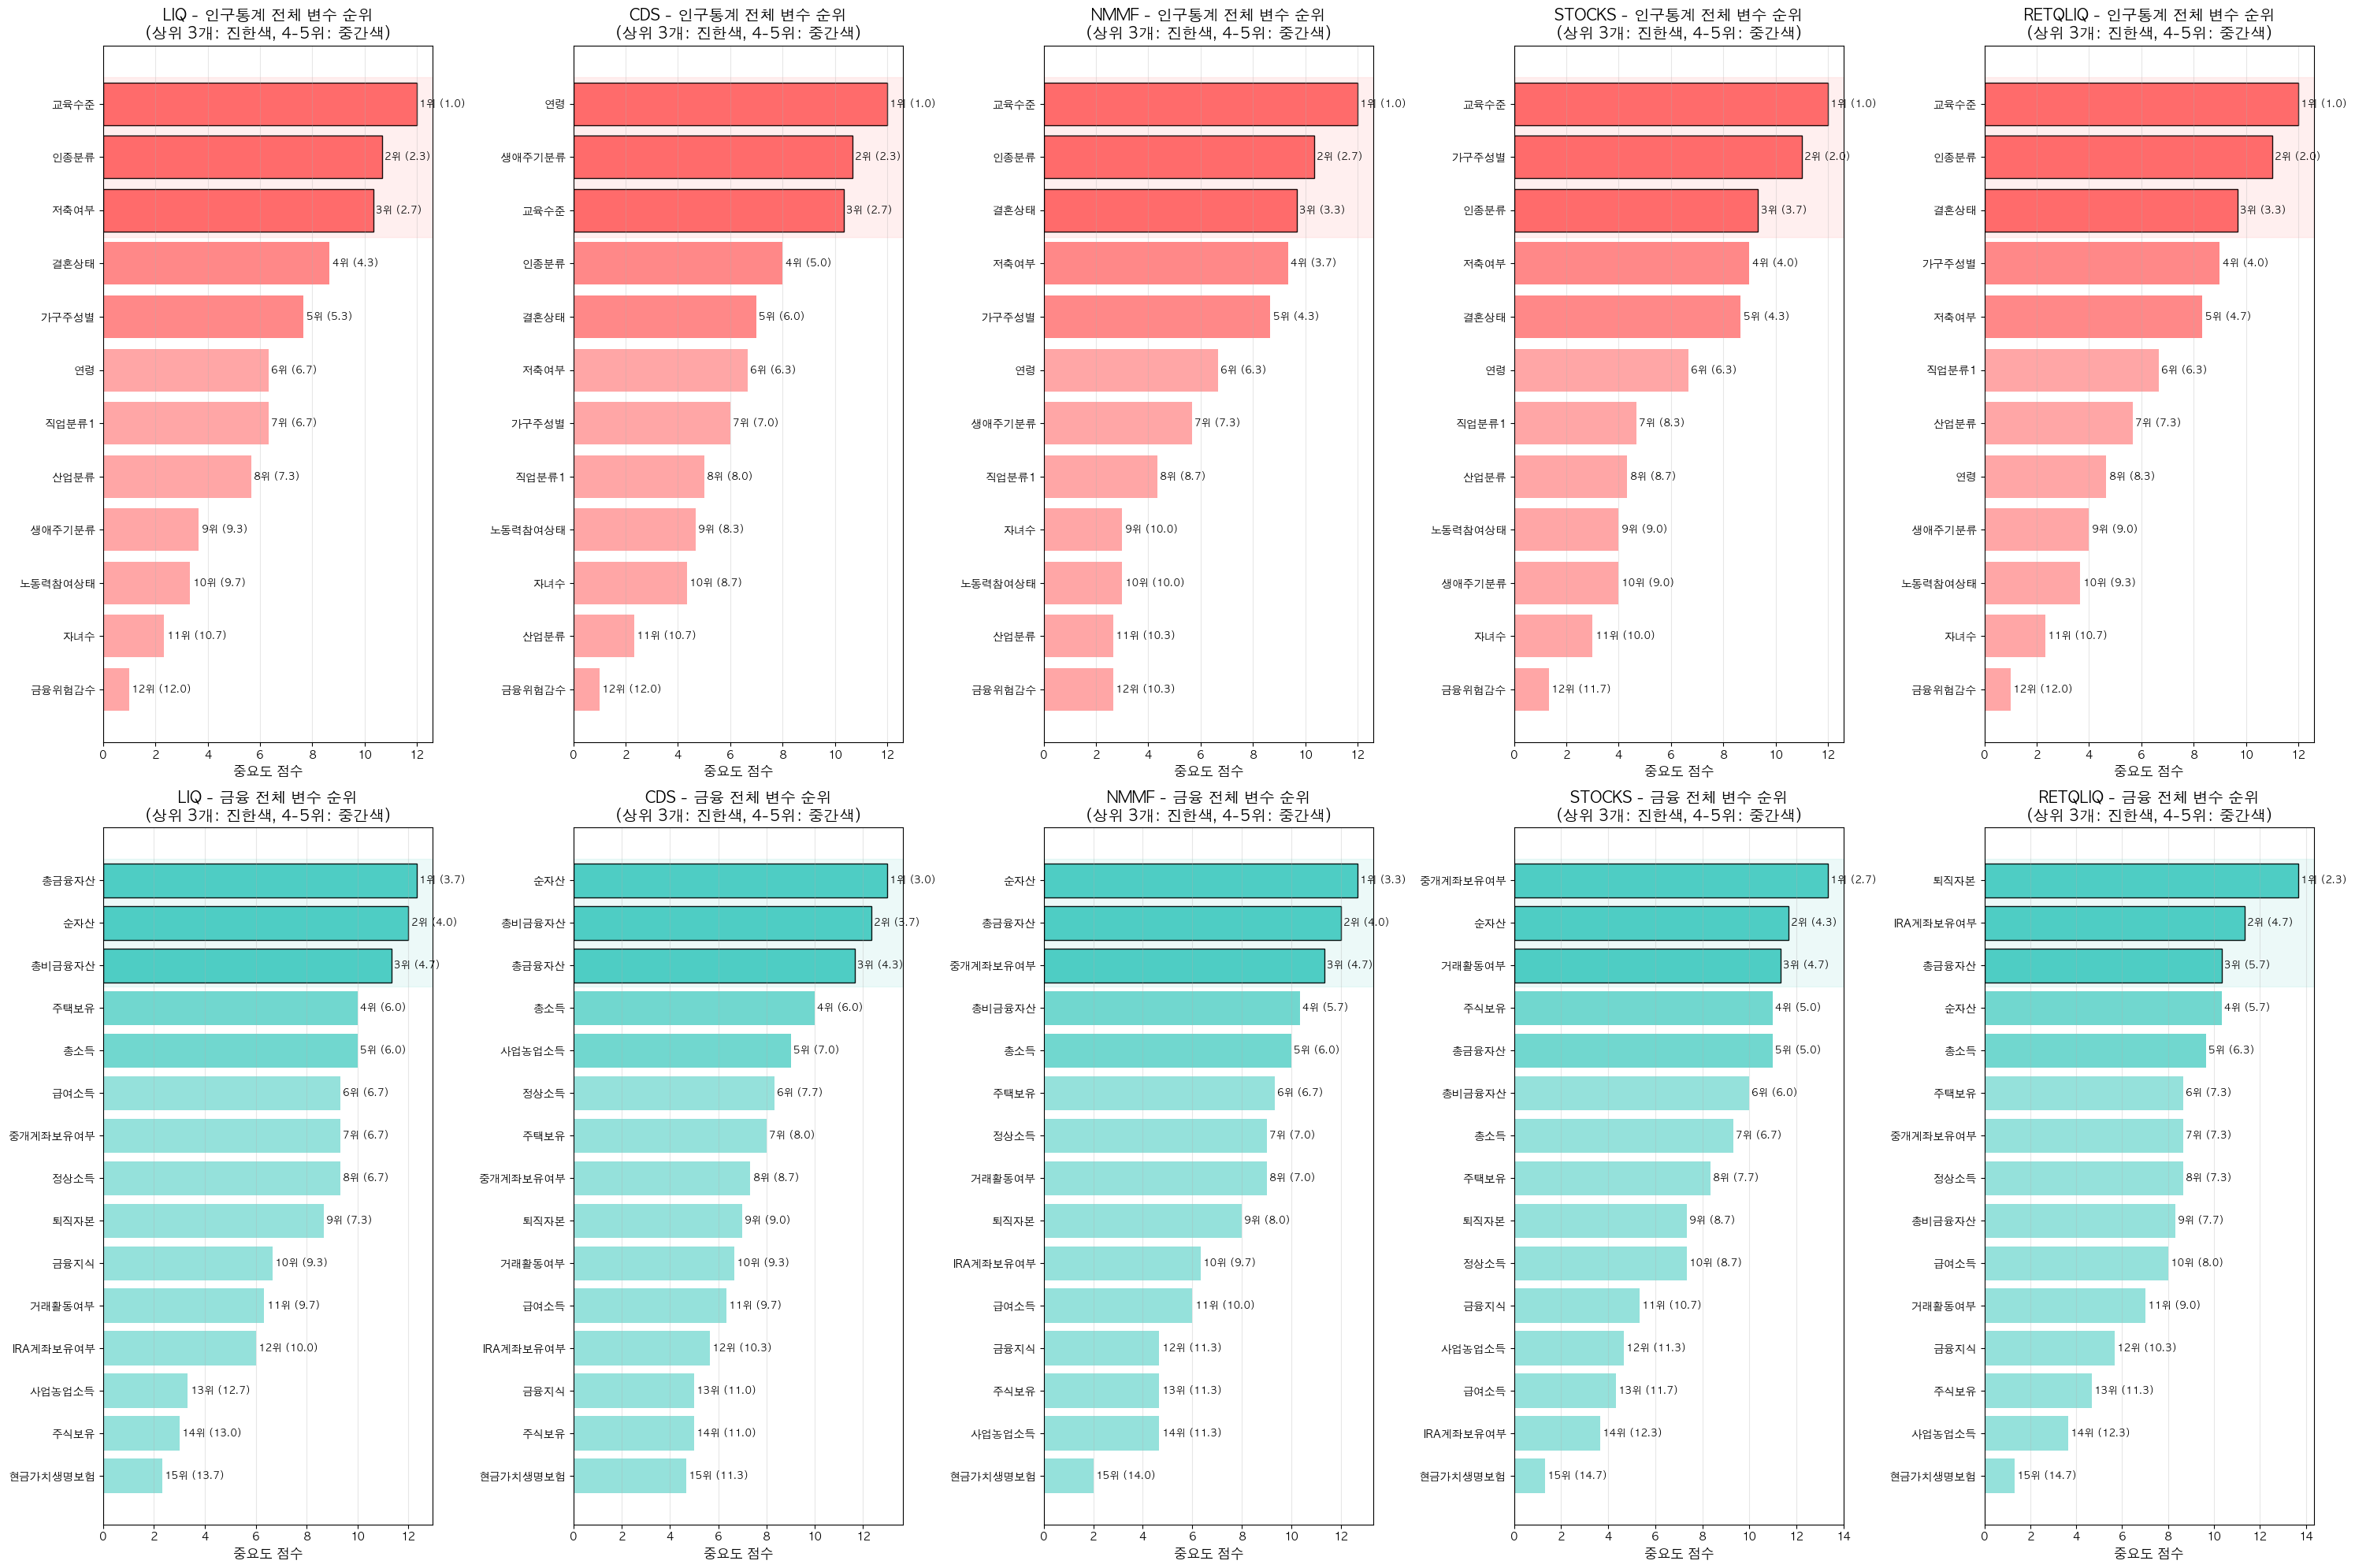


2️⃣ 전체 변수 히트맵 비교


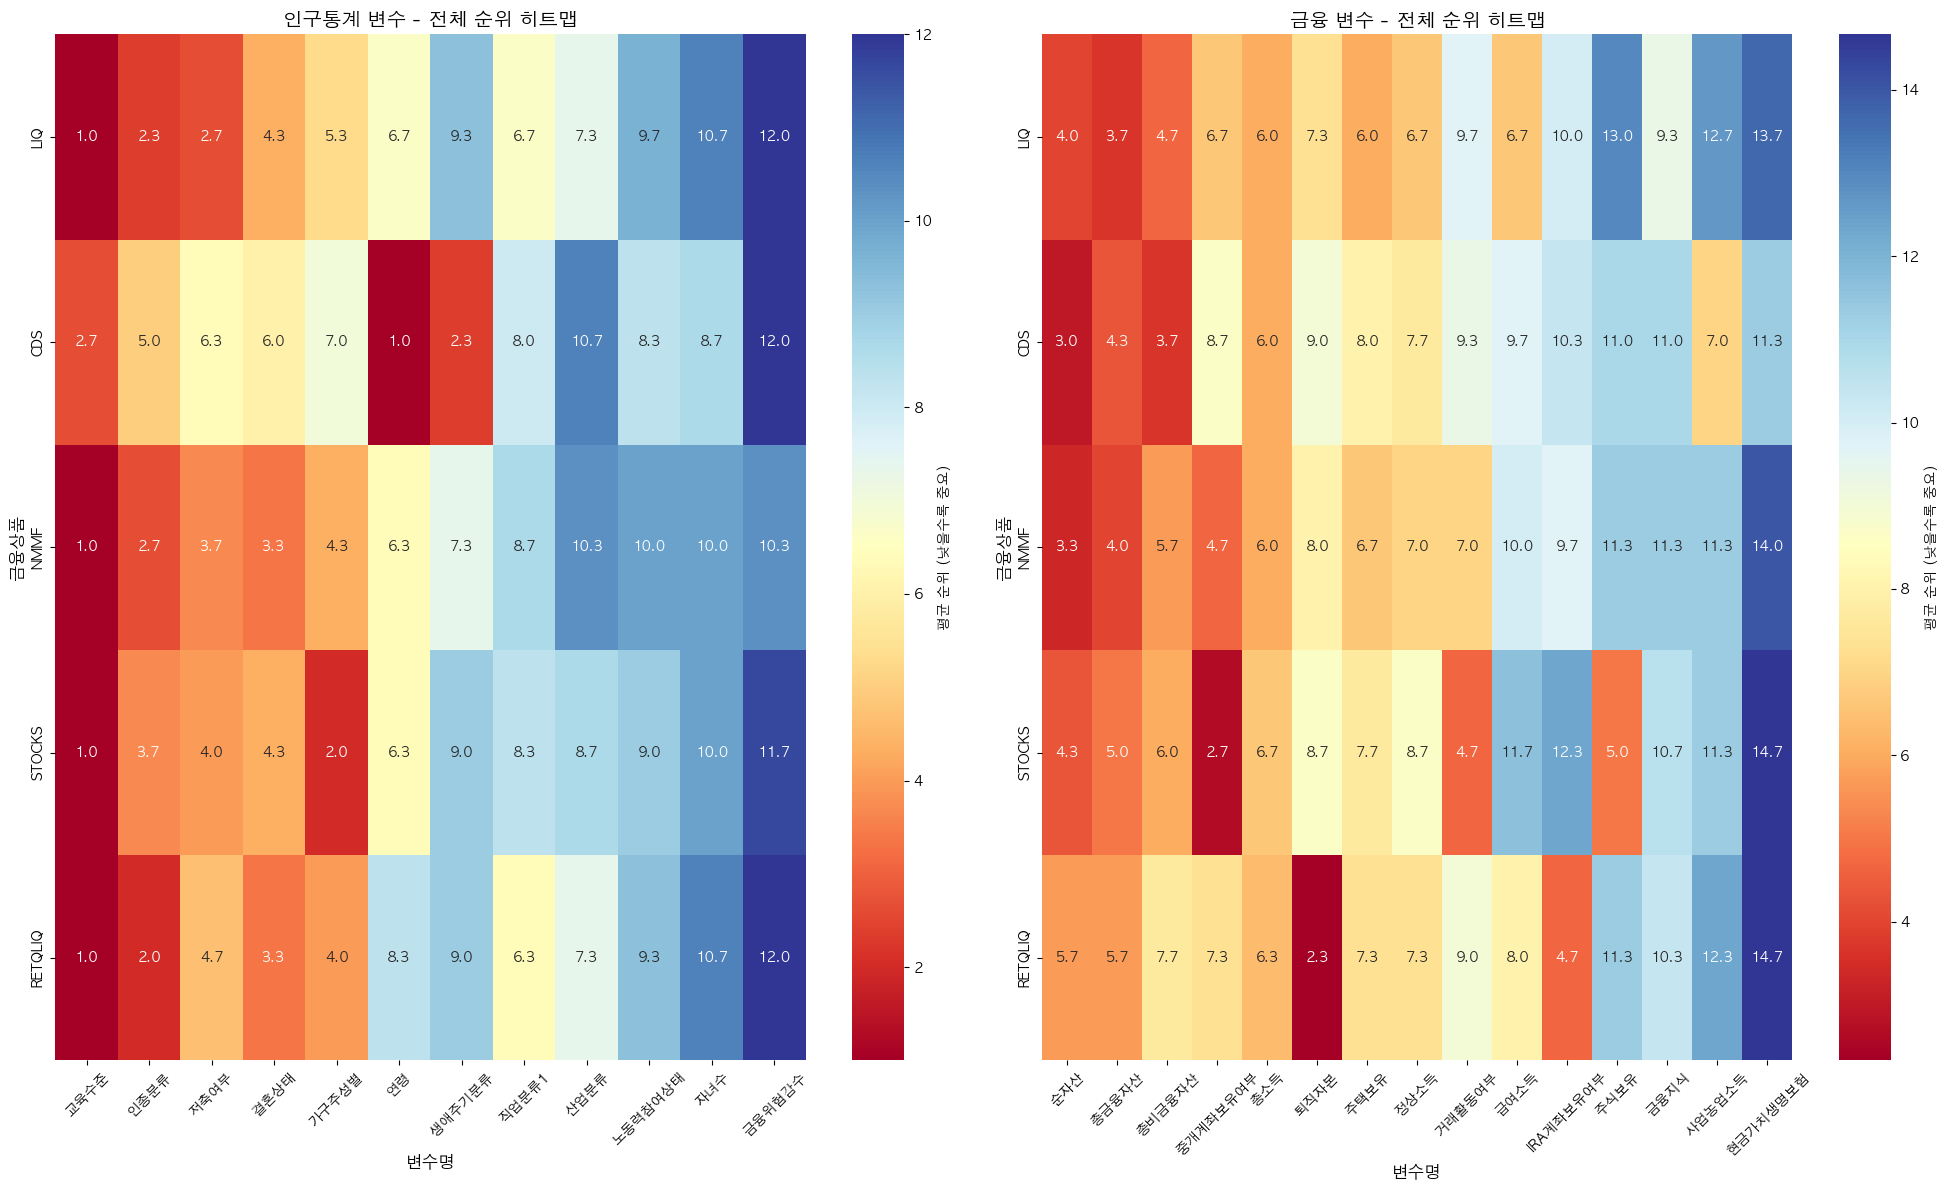


3️⃣ 상위/하위 변수 분석


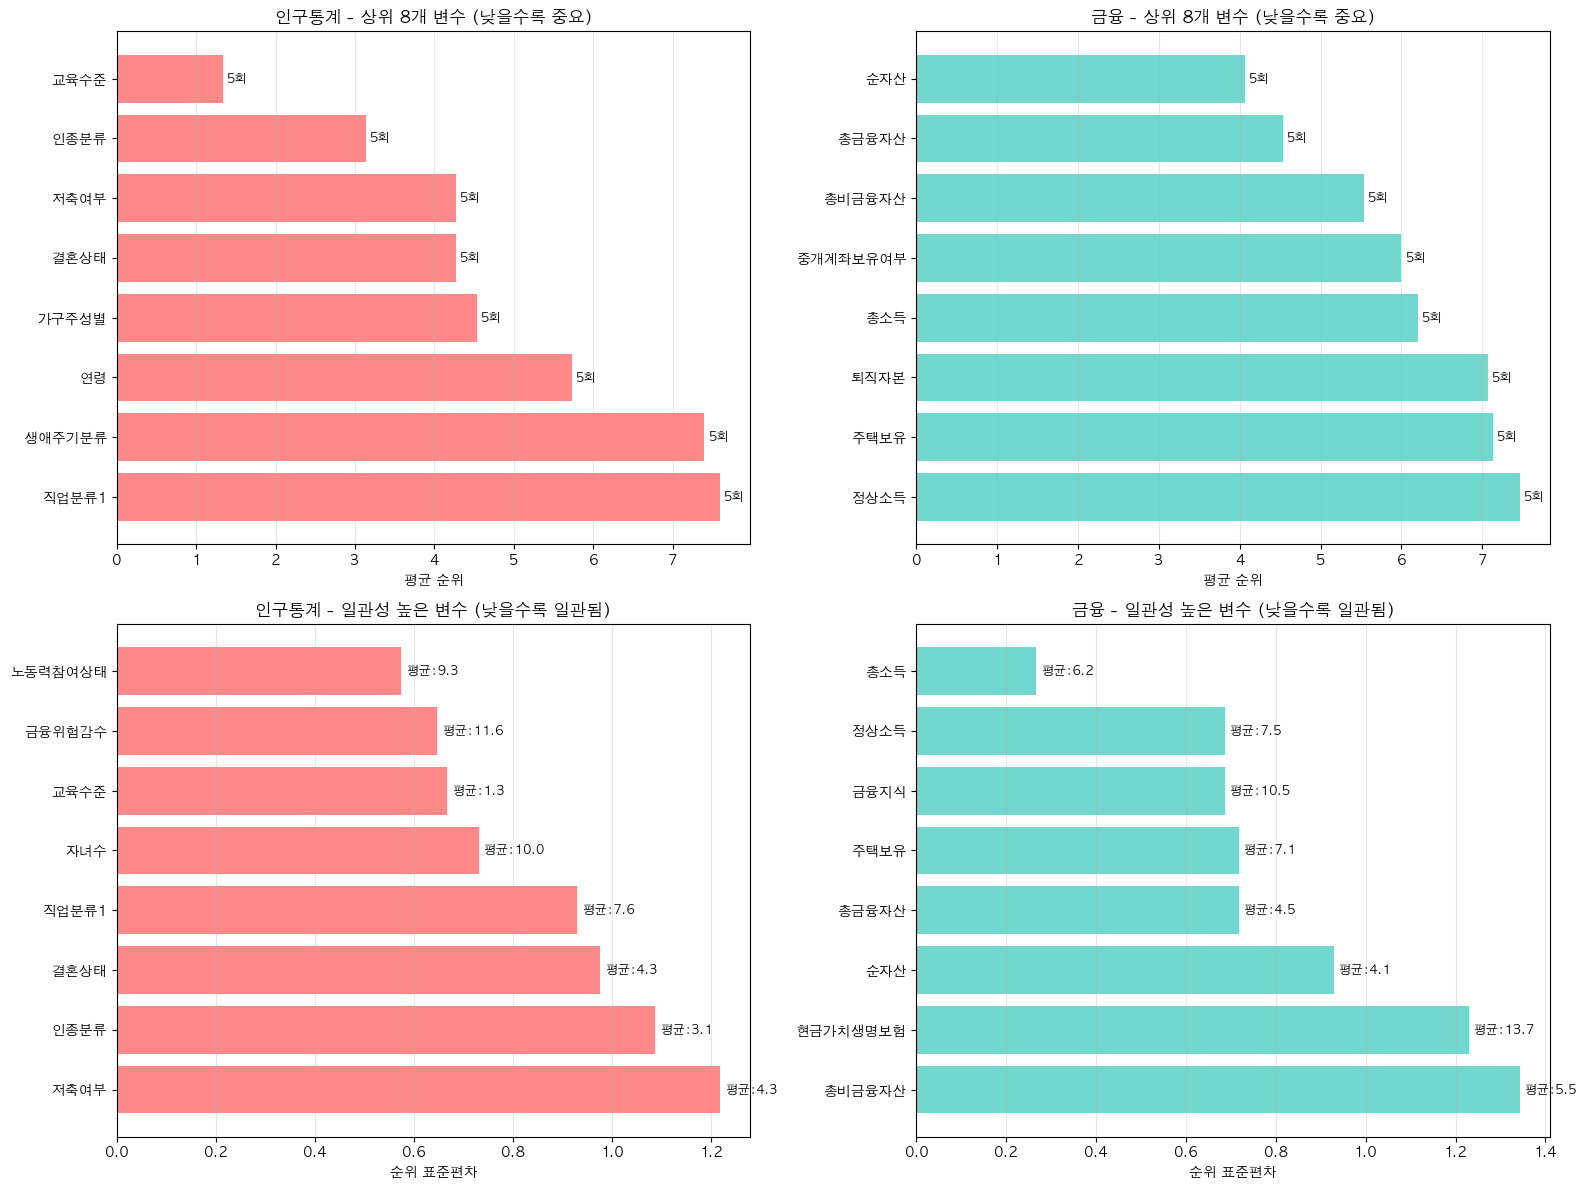


4️⃣ 변수별 일관성 분석 및 종합 순위


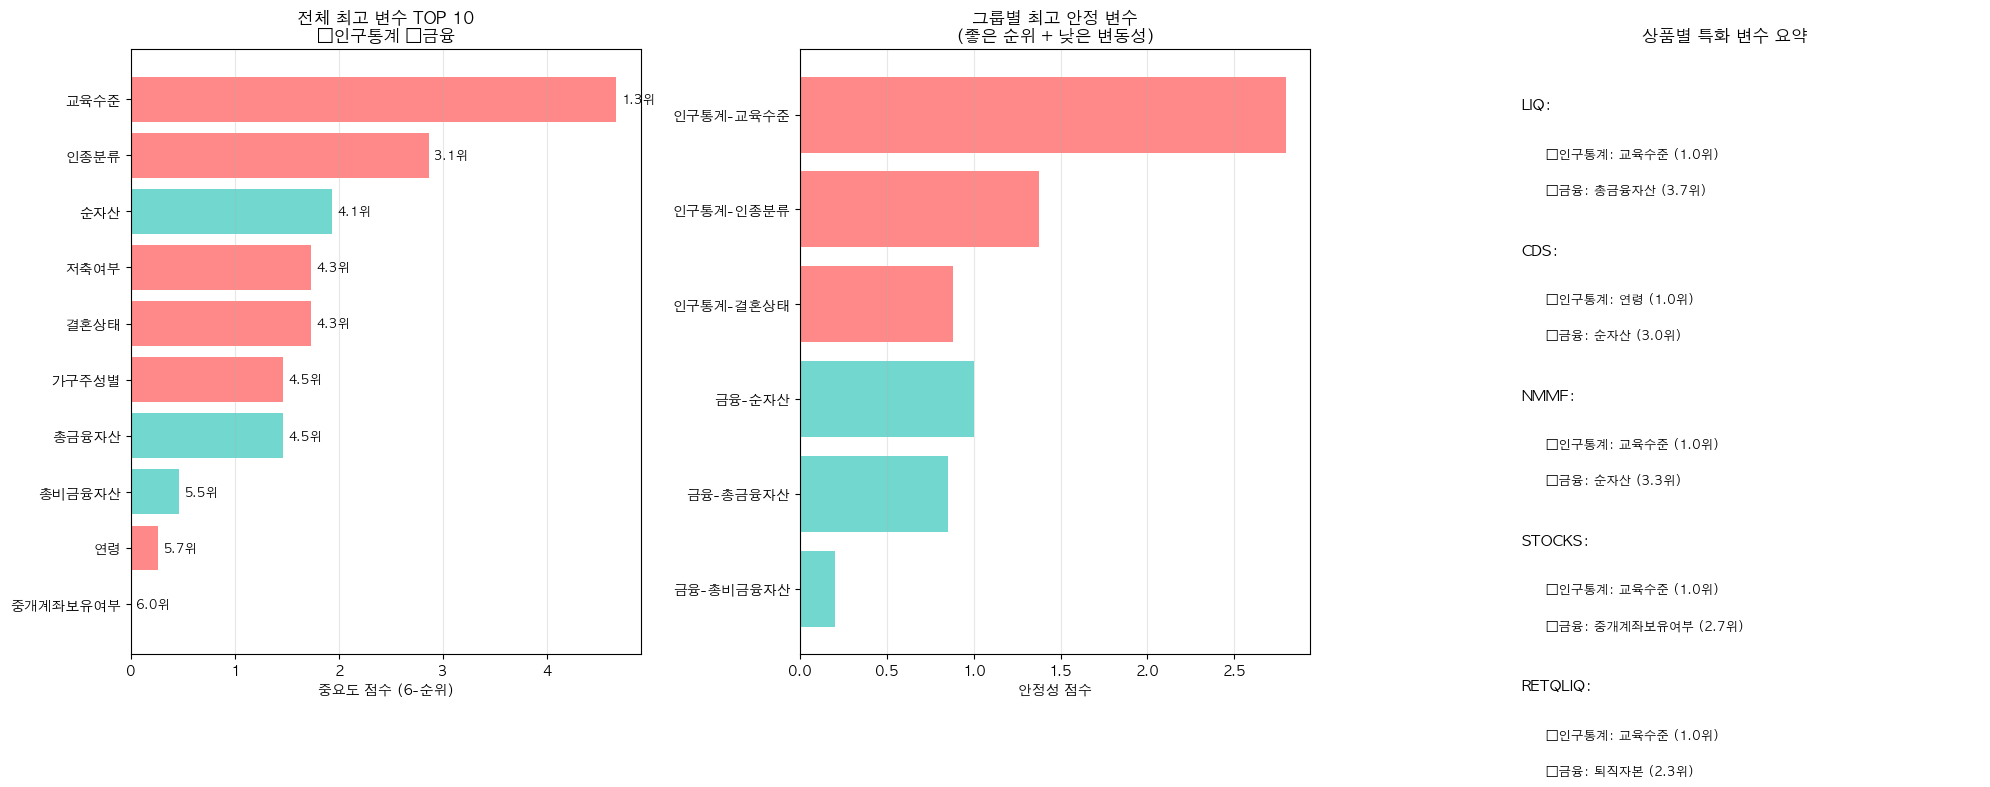


5️⃣ 전체 변수 요약 통계

📊 상위 20개 변수 종합 통계:
         변수명 평균순위 평균위치 최고순위 최저순위  일관성  등장횟수
   인구통계-교육수준  1.3  1.4  1.0  2.7 0.67     5
   인구통계-인종분류  3.1  2.6  2.0  5.0 1.09     5
      금융-순자산  4.1  2.0  3.0  5.7 0.93     5
   인구통계-저축여부  4.3  4.4  2.7  6.3 1.22     5
   인구통계-결혼상태  4.3  4.0  3.3  6.0 0.98     5
  인구통계-가구주성별  4.5  4.6  2.0  7.0 1.64     5
    금융-총금융자산  4.5  2.8  3.7  5.7 0.72     5
   금융-총비금융자산  5.5  4.8  3.7  7.7 1.34     5
     인구통계-연령  5.7  5.4  1.0  8.3 2.48     5
 금융-중개계좌보유여부  6.0  5.2  2.7  8.7 2.11     5
      금융-총소득  6.2  5.2  6.0  6.7 0.27     5
     금융-퇴직자본  7.1  7.4  2.3  9.0 2.43     5
     금융-주택보유  7.1  6.2  6.0  8.0 0.72     5
 인구통계-생애주기분류  7.4  7.4  2.3  9.3 2.63     5
     금융-정상소득  7.5  7.8  6.7  8.7 0.69     5
  인구통계-직업분류1  7.6  7.2  6.3  8.7 0.93     5
   금융-거래활동여부  7.9  8.6  4.7  9.7 1.88     5
   인구통계-산업분류  8.9  9.0  7.3 10.7 1.42     5
     금융-급여소득  9.2 10.2  6.7 11.7 1.72     5
인구통계-노동력참여상태  9.3  9.6  8.3 10.0 0.57     5

💡 해석 가이드:
- 평균순위: 낮을수록 중요 (1위가 최고)
- 일

In [33]:
run_expanded_visualization_all_features(results, targets)